Install Packages

In [210]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage
from pprint import pprint
from typing import Any, Dict, List
import logging

In [211]:
logger = logging.getLogger(__name__)
logger.info("Hello")

Enable Langsmith Tracing for Future Observability

In [212]:
load_dotenv()


True

In [213]:
llm = ChatOpenAI(model="gpt-4.1-nano", temperature=0.7)
llm

ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x144c7d640>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x144c553d0>, root_client=<openai.OpenAI object at 0x144c91d60>, root_async_client=<openai.AsyncOpenAI object at 0x144c91c70>, model_name='gpt-4.1-nano', temperature=0.7, model_kwargs={}, openai_api_key=SecretStr('**********'))

In [214]:
response = llm.invoke("hello, how are you ")

Structuring the messages

In [ ]:
messages = [
    SystemMessage("yYou are a helpful AI assistant that explains complex topics simply."),
    HumanMessage("what can you do for me?"),
]

In [247]:
# llm.invoke(messages)

Addition of tools 

In [248]:
from langchain_core.tools import tool
from langchain_community.tools import DuckDuckGoSearchRun


In [285]:
#WEATHER TOOL
@tool 
def weather_tool(location:str) -> str:
    """Return the weather of the city and forecast for next 5 days"""
    try:
        print("==TOOL CALL -> WEATHER==")
        # Logic to send the weather update
        return "London is having weather of 12 degree centrigrate and in next five days consistent weather"
    except Exception as e:
        logger.warning(f"Error occured with Exception {e}")

In [286]:
# calculator tool
@tool
def calculator(expression: str) -> str:
    """Calculate mathematical expressions. Use this for any math calculations."""
    try:
        print("==TOOL CALL -> CALCULATOR==")
        calculated_answer = eval(expression)
        return f"Calculated answer of the express is : {calculated_answer}"
    except Exception as e:
        return f"Error occured while calculating the expression {expression}: {e}"


In [287]:
# WEB browsing
search_tool = DuckDuckGoSearchRun()

In [288]:
tools = [calculator, search_tool, weather_tool]
llm_with_tools = llm.bind_tools(tools)

In [289]:
tool_map = {

    "calculator": calculator,
    "duckduckgo_search": search_tool,
    "weather_tool": weather_tool
}

In [290]:
import logging
logger = logging.getLogger(__name__)
def handle_too_call(response, tool_map):
    try:
        if not getattr(response, 'tool_calls', None):
            return "No Tool call possible"
        for tool_call in response.tool_calls:
            tool_name = tool_call['name']
            args = tool_call['args']
            tool = tool_map.get(tool_name)
            if tool:
                result = tool.invoke(args)
                return result

    except Exception as e:
        logger.infof(f"===Error in Handling TOOL call=== {str(e)}")
        raise "Error occured while handling Tool Call"

In [291]:
def check_tool_is_working(query:str):
    response = llm_with_tools.invoke(query)
    return handle_too_call(response, tool_map)

In [292]:
print(check_tool_is_working("what is 2+2"))
print(check_tool_is_working("what is weather in london"))
print(check_tool_is_working("search web about latest news "))

==TOOL CALL -> CALCULATOR==
Calculated answer of the express is : 4
==TOOL CALL -> WEATHER==
London is having weather of 12 degree centrigrate and in next five days consistent weather
View the latest news and breaking news today for U.S., world, weather, entertainment, politics and health at CNN.com. Latest news ... Latest UK News ... Party President Mark Pack’s latest report back to members. Latest News ... Business Business Plans Cryptocurrency Cybersecurity Education Entertainment Fintech Marketing Media Mental Health Nasdaq News ... You can get the latest Debian news by subscribing to or browsing the archives for our debian-announce and debian- news mailing lists. Read the Latest Entertainment and Celebrity News , TV News and Breaking News from TVGuide.com


In [293]:
search_tool.invoke("what is machine learning")

'28 Apr 2025 — Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data In this article, you’ll learn more about what machine learning is , including how it works, its different types, and how it s actually used in the ... ... machine learning serves as a primer on this important field, ... Continue Reading About What is machine learning ? Guide, definition and examples Machine learning (ML) is the process of teaching a computer system to make predictions based on a set of data. ... examples of machine learning is a ... In supervised learning , the most prevalent, the data is labeled to tell the machine exactly what patterns it should look for.'

Look carefully, 
First we inialized the llm, also with system messages/human messages
further we got the tools 
create generic tools also imported existing tool
we then assigned tool with its respected dictionary to perform toolcall
finally we did the tool call

Structured Output from the LLM

In [389]:
from pydantic import BaseModel,Field
from typing import Optional, List

class PersonalDetails(BaseModel):
    username:str = Field(..., description="Username of the whatsapp user")
    email:str = Field(description="Email address")
    nationality:Optional[str] = Field(description="Nationality of the User")
    services:List[str] = Field(description="List of services user are interested")

llm_with_structure = llm.with_structured_output(PersonalDetails)


In [390]:
person_details = llm_with_structure.invoke("my user name is John Doe and my email is kandelsudip245@gmail.com and nationality is Nepali, alos my services are mostly in Telecom and healthcare")


In [370]:
person_details

PersonalDetails(username='John Doe', email='kandelsudip245@gmail.com', nationality='Nepali', services=['Telecom', 'Healthcare'])

In [372]:
# Basic Chatbot Langgrpah
from langchain_core.messages import (BaseMessage, 
                                     SystemMessage, 
                                     HumanMessage, 
                                     AIMessage)
from langgraph.graph import START, END, StateGraph, add_messages
from typing import Annotated, TypedDict

In [ ]:
class State(TypedDict):
    messages = Annotated[list[BaseMessage], add_messages]

llm = ChatOpenAI(model='gpt-4.1-nano',
                 temperature=0.7)


Now lets create a node

In [377]:
def chatbot_node(state: State) -> State:
    response = llm.invoke(state['messages'])
    return {'messages':  [response]}

Lets build the graph

In [449]:
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot_node)
graph_builder.add_edge(START,"chatbot")
graph_builder.add_edge('chatbot',END)
# graph = graph_builder.compile()

In [399]:

class State(TypedDict):
    """State for our chatbot - this holds the conversation history"""
    # The add_messages function handles appending new messages to the conversation
    messages: Annotated[list[BaseMessage], add_messages]

# Initialize the LLM
llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0.7)

In [400]:

def chatbot_node(state: State) -> State:
    """
    The main chatbot node that processes messages and generates responses
    """
    print(f"Processing {len(state['messages'])} messages")

    # Get the response from the LLM
    response = llm.invoke(state["messages"])

    # Return the updated state with the new response
    return {"messages": [response]}

print("Chatbot node function created")

Chatbot node function created


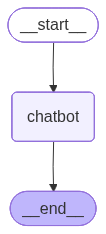

In [423]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [445]:
def check_chatbot(messages: str):
    initial_state = {"messages": HumanMessage(content=messages)}
    response = graph.invoke(initial_state)
    ai_response = response['messages'][-1].content
    print("HUMAN REQUEST -->", messages)
    print("AI RESPONSE -->", ai_response)
    print("\n\n")
    return initial_state


In [446]:
test_cases = [
    "hello how are you",
    "do you remember my name?"
]
for test_message in test_cases:
    check_chatbot(test_message)

HUMAN REQUEST --> hello how are you
AI RESPONSE --> Hello! I'm just a program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?



HUMAN REQUEST --> do you remember my name?
AI RESPONSE --> I don’t have the ability to remember personal information or previous interactions. How can I assist you today?





In [447]:
#Adding memory to the chatbot 

In [451]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

graph_with_memory = graph_builder.compile(checkpointer=memory)

In [471]:
def chat_with_memory(message: str, thread_id: str):
    config = {"configurable": {"thread_id": thread_id}}
    initial_state = {"messages": [HumanMessage(content=message)]}
    result = graph_with_memory.invoke(initial_state, config)
    ai_response = result["messages"][-1].content
    print("AI response", ai_response)

In [476]:
chat_with_memory("hello my name is sudip", thread_id="thread-1")
chat_with_memory("my name is sanjana", thread_id="thread-2")
chat_with_memory("what is my name", thread_id="thread-2")

AI response Hello, Sudip! How can I assist you today?
AI response Nice to meet you, Sanjana! How can I assist you today?
AI response Your name is Sanjana. How can I help you today?


In [477]:
# Langgraph agents with tools